# 3.4 Stacking and interpolating data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3.4-Stacking-and-interpolating-data" data-toc-modified-id="3.4-Stacking-and-interpolating-data-1">3.4 Stacking and interpolating data</a></span><ul class="toc-item"><li><span><a href="#3.4.1-Introduction" data-toc-modified-id="3.4.1-Introduction-1.1">3.4.1 Introduction</a></span><ul class="toc-item"><li><span><a href="#3.4.1.1-Test-your-login" data-toc-modified-id="3.4.1.1-Test-your-login-1.1.1">3.4.1.1 Test your login</a></span></li><li><span><a href="#3.4.1.2-Get-the-datasets-for-today" data-toc-modified-id="3.4.1.2-Get-the-datasets-for-today-1.1.2">3.4.1.2 Get the datasets for today</a></span></li></ul></li><li><span><a href="#3.4.2-A-time-series" data-toc-modified-id="3.4.2-A-time-series-1.2">3.4.2 A time series</a></span></li></ul></li></ul></div>

[[up to 3.0](Chapter3_1_GDAL.ipynb)]


## 3.4.1 Introduction

In this section, we will:

* develop code to produce a stacked dataset of spatio-temporal data on a grid
* interpolate over any missing data
* smooth the dataset

### 3.4.1.1 Test your login

Let's first test your NASA login:

In [ ]:
import geog0111.nasa_requests as nasa_requests
from geog0111.cylog import cylog
%matplotlib inline

url = 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/' 
        
# grab the HTML information
try:
    html = nasa_requests.get(url).text
    # test a few lines of the html
    if html[:20] == '<!DOCTYPE HTML PUBLI':
        print('this seems to be ok ... ')
        print('use cylog().login() anywhere you need to specify the tuple (username,password)')
except:
    print('login error ... try entering your username password again')
    print('then re-run this cell until it works')
    cylog(init=True)

### 3.4.1.2 Get the datasets for today

Now let's get the datasets we need for today.

**You should run this section before the class starts to save time.**

You are given the relevant filenames (for 2016 and 2017 `MCD15A3H` data for the tiles `h1[7-8]v0[3-4]`) in the files [`data/lai_filelist_{year}.dat.txt`](data/lai_filelist_2016.dat.txt). The datasets have been pre-downloaded for this exercise, but you need to copy then to the local filespace:

In [15]:
from geog0111.geog_data import *

destination_folder = 'data'

# we have the filenames provided 
# in data/lai_filelist_2016.dat.txt
for year in [2016,2017]:
    control_file = f'data/lai_filelist_{year}.dat.txt'
    # read the ascii data from the file in
    filenames = open(control_file).read().split()

    # get the local files
    # set verbose=True if you want to see what is happening
    # in procure_dataset()
    done = [procure_dataset(f,\
                verbose=False,\
                destination_folder=destination_folder) 
                                    for f in filenames]
    # done should be all True if this has worked
    # its length should be the number of files copied

    # get the dataset names
    dataset_names = [f'HDF4_EOS:EOS_GRID:"{destination_folder}/{file_name:s}":MOD_Grid_MCD15A3H:Lai_500m'
                   for file_name in filenames]

    # print the first 8 in the list, just to see it looks ok
    print(f'\n {year}\n','*'*len(str(year)))
    for f in dataset_names[:8]:
        print (f)



 2016
 ****
HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2016001.h17v03.006.2016007075833.hdf":MOD_Grid_MCD15A3H:Lai_500m
HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2016001.h17v04.006.2016007074809.hdf":MOD_Grid_MCD15A3H:Lai_500m
HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2016001.h18v03.006.2016007073724.hdf":MOD_Grid_MCD15A3H:Lai_500m
HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2016001.h18v04.006.2016007073726.hdf":MOD_Grid_MCD15A3H:Lai_500m
HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2016005.h17v03.006.2016013012017.hdf":MOD_Grid_MCD15A3H:Lai_500m
HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2016005.h17v04.006.2016013011406.hdf":MOD_Grid_MCD15A3H:Lai_500m
HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2016005.h18v03.006.2016013012348.hdf":MOD_Grid_MCD15A3H:Lai_500m
HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2016005.h18v04.006.2016013012025.hdf":MOD_Grid_MCD15A3H:Lai_500m

 2017
 ****
HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017001.h17v03.006.2017014005341.hdf":MOD_Grid_MCD15A3H:Lai_500m
HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2017001.h17v04.006.2017014005344.hdf":MOD_Grid_MC

## 3.4.2 A time series

You should now know how to access and download datasets from the NASA servers and have developed functions to do this.

You should also know how to select a dataset from a set of hdf files, and mosaic, mask and crop the data to correspond to some vector boundary. This is a very common task in geospatial processing.

We now consider the case where we want to analyse a time series of data. We will use LAI over time to exemplify this.



In [18]:
import gdal
import numpy as np

opfile = 'tmp/xx_'

vrts = []
for i in range(0,len(dataset_names),4):
    # build spatial dataset called f'{opfile}{i:03d}.vrt'
    g = gdal.BuildVRT(f'{opfile}{i:03d}.vrt', dataset_names[i:i+4])
    g = gdal.Warp(f'{opfile}{i:03d}_clip.tif',
                   f'{opfile}{i:03d}.vrt',
                   format = 'GTiff', dstNodata=200,
                   cutlineDSName='data/TM_WORLD_BORDERS-0.3.shp',
                   cutlineWhere = "FIPS='BE'",
                   cropToCutline=True)
    vrts.append(f'{opfile}{i:03d}_clip.tif')
    
# now build the timer series
g = gdal.BuildVRT(f'{opfile}all.vrt', vrts,separate=True)

In [30]:
import gdal
import numpy as np

opfile = 'tmp/xx_'

vrts = []
for i in range(0,len(dataset_names),4):
    # build spatial dataset called f'{opfile}{i:03d}.vrt'
    g = gdal.BuildVRT(f'{opfile}{i:03d}.vrt', dataset_names[i:i+4])
    g = gdal.Warp(f'{opfile}{i:03d}_clip.vrt',
                   f'{opfile}{i:03d}.vrt',
                   format = 'VRT', dstNodata=200,
                   cutlineDSName='data/TM_WORLD_BORDERS-0.3.shp',
                   cutlineWhere = "FIPS='BE'",
                   cropToCutline=True)
    vrts.append(f'{opfile}{i:03d}_clip.vrt')
    
# now build the timer series
g = gdal.BuildVRT(f'{opfile}all.vrt', vrts,separate=True)

In [31]:
import gdal
import numpy as np
opfile = 'tmp/xx_'

g = gdal.Open(f'{opfile}all.vrt')
lai = np.array([g.GetRasterBand(b+1).ReadAsArray() for b in range(g.RasterCount)]).astype(float) * 0.1 # for LAI scaling
print(lai.shape)

(92, 480, 597)


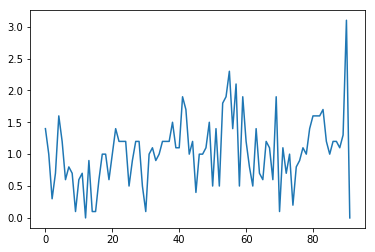

In [32]:
import matplotlib.pylab as plt
%matplotlib inline

plt.plot(lai[:,100,100])

In [ ]:
    import imageio
    from glob import glob
    images = []
    filenames = sorted(glob('images/f_iso_0.???.png'))
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('images/movie.gif', images)

In [ ]:
g = gdal.Open(f'{opfile}all.vrt')
lai = np.array(g.ReadAsArray()).astype(float) * 0.1 # for LAI scaling
print(lai.shape)




In [ ]:
print(lai.shape)

In [ ]:
g = gdal.Warp('', , 
                  format = 'MEM', dstNodata=200,
                  cutlineDSName = "data/TM_WORLD_BORDERS-0.3.shp",
                  cutlineWhere = "FIPS='BE'")
print(g)

In [ ]:
print(g)
lai = np.array(g.ReadAsArray()).astype(float) * 0.1 # for LAI scaling
print(lai.shape)

In [ ]:

lai = np.array(stitch_vrt.ReadAsArray()).astype(float) * 0.1
print (lai.shape)
lai[lai>10] = np.nan
lai[lai==0] = np.nan
plt.imshow(lai,cmap='Greys',vmin=0,vmax=4)

In [ ]:
import gdal
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

#def process_data(doy_year,tiles,vector_file, vector_where):
    
    
def mosaic_and_mask_data(gdal_fnames, vector_file, vector_where):
    stitch_vrt = gdal.BuildVRT("", gdal_fnames)
    g = gdal.Warp("", stitch_vrt,
                 format = 'MEM', dstNodata=200,
                  cutlineDSName = vector_file,
                  cutlineWhere = vector_where)
    return g



g = mosaic_and_mask_data(dataset_names[:8], "data/TM_WORLD_BORDERS-0.3.shp",
                         "FIPS='GM'")

lai = np.array(g.ReadAsArray()).astype(float) * 0.1 # for LAI scaling
# valid data mask
mask = np.nonzero(lai < 20)
min_y = mask[0].min()
max_y = mask[0].max() + 1

min_x = mask[1].min()
max_x = mask[1].max() + 1

lai = lai[min_y:max_y,
               min_x:max_x]

fig = plt.figure(figsize=(12,12))
im = plt.imshow(lai, interpolation="nearest", vmin=0, vmax=6,
             cmap=plt.cm.inferno_r)
plt.title('LAI'+' '+str(tiles)+' '+str((doy,year)))
plt.colorbar()